In [ ]:
# Load model directly
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import requests
import numpy as np
processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf",device_map="cuda:0")
model = AutoModelForVision2Seq.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf",device_map="cuda:0",dtype='float16')
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "/projects/_hdd/Datazx/coco_val_images/val2014/COCO_val2014_000000581929.jpg"},
            {"type": "text", "text": "Describe the image in detail."}
        ]
    },
]



/home/zhaoxu.li/.conda/envs/EHA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/_ssd/ZhaoxuCode/Efficient-HA/transformers-4.57.3/src/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/projects/_ssd/ZhaoxuCode/Efficient-HA/transformers-4.57.3/src/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated an

In [12]:
inputs = processor.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)


{'input_ids': tensor([[    1,   733, 16289,  ..., 28748, 16289, 28793]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[[[[ 0.0471,  0.0179,  0.0617,  ...,  0.0617,  0.0617,  0.0325],
           [ 0.0471, -0.2448, -0.1864,  ..., -0.2448, -0.0550,  0.0471],
           [-0.0405, -0.1718, -0.1864,  ..., -0.2594, -0.2740,  0.0471],
           ...,
           [ 0.0179,  0.1201,  0.5581,  ..., -0.0842,  0.0471,  0.0617],
           [ 0.0033, -0.1718,  0.0179,  ..., -0.1426,  0.0325,  0.0471],
           [ 0.0471,  0.0325,  0.0617,  ...,  0.0763,  0.0471,  0.0325]],

          [[-0.7616, -0.7466, -0.7766,  ..., -0.7766, -0.7916, -0.7766],
           [-0.8066, -0.7766, -0.5815,  ..., -0.6565, -0.5365, -0.7316],
           [-0.8216, -0.4014, -0.2363,  ..., -0.2663, -0.3564, -0.7616],
           ...,
           [-0.7766, -0.1313,  0.4090,  ...,  0.1389,  0.0338, -0.7616],
           [-0.7766, -0.6715, -0.4464,  ..., -0.4464, -0.4

2436
torch.Size([1, 5, 3, 336, 336])


In [42]:
import torch
outputs = model.generate(**inputs, max_new_tokens=40,return_dict_in_generate=True, output_hidden_states=True)



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [31]:
x = torch.stack(outputs.hidden_states[0]).max(dim=1).values

logits = []
for i in range(x.shape[0]):
    with torch.no_grad():
        logits.append(model.lm_head(x[i, :, :]).detach().cpu())

logit_lens = torch.stack(logits)

with torch.no_grad():
    softmax_probs = torch.softmax(logit_lens, dim=-1)

softmax_probs = softmax_probs.permute(2, 0, 1)
print(softmax_probs.shape)
try:
    image_token_region = softmax_probs[:, :, 5:5+24*24]

except Exception as e:
    print(f"Warning: Error slicing token region: {e}")
    print(f"Softmax probs shape: {softmax_probs.shape}")
    image_token_region = softmax_probs

image_token_region = image_token_region.detach().cpu().numpy()

torch.Size([32064, 33, 2455])


In [18]:
print(image_token_region.shape)

(32064, 33, 576)


In [19]:

def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


In [20]:
image=load_image("/projects/_hdd/Datazx/coco_val_images/val2014/COCO_val2014_000000581929.jpg")


In [21]:
img_width, img_height = image.size
print(f"Image size: width={img_width}, height={img_height}")

Image size: width=640, height=509


In [ ]:
tokenizer=processor.tokenizer
ids=tokenizer.encode("horse")[1:]
print(image_token_region.shape)


(32064, 33, 576)
Token IDs for 'horse': [7947]


In [39]:
att_map= image_token_region[ids].max(axis=0).max(axis=0).reshape(24, 24).astype(float)


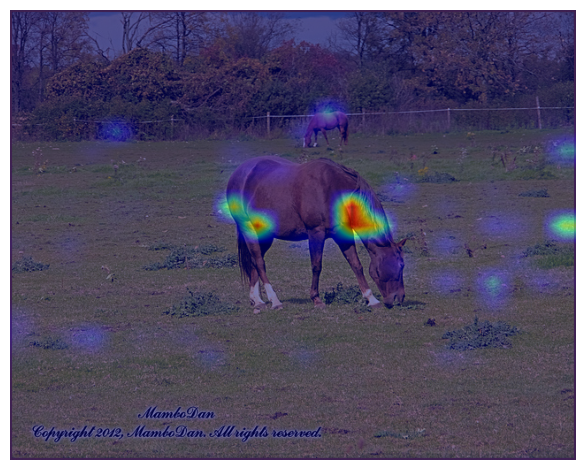

In [ ]:



segmentation_resized = (np.array(Image.fromarray(att_map).resize((img_width, img_height), Image.BILINEAR)))
plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
plt.axis('off')

plt.tight_layout()
plt.show()